In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### resnet50

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Verify GPU setup
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

# Define the base path
base_path = "/content/drive/My Drive/preprocessed"

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'



Num GPUs Available:  1
TensorFlow version: 2.15.0


In [ ]:
# Convert lists to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)

# Convert labels to categorical
labels = to_categorical(labels, num_classes=2)

# Split the data into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)


In [ ]:

# Function to load and preprocess images
def load_and_preprocess_image(file_path, label, target_size=(224, 224)):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = preprocess_input(image)  # Preprocess the image for ResNet
    return image, label

# Data Augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomContrast(factor=0.1)
])



In [ ]:
# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Create validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



In [ ]:
# Load the ResNet50 model pre-trained on ImageNet and exclude the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers with dropout and regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.6)(x)  # Add dropout layer
predictions = Dense(2, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)



In [ ]:

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[early_stopping])



Epoch 1/5
55/55 [==============================] - 26s 400ms/step - loss: 8.9609 - accuracy: 0.7983 - val_loss: 4.4938 - val_accuracy: 0.8637
Epoch 2/5
55/55 [==============================] - 21s 387ms/step - loss: 3.1524 - accuracy: 0.8630 - val_loss: 2.1217 - val_accuracy: 0.8776
Epoch 3/5
55/55 [==============================] - 21s 386ms/step - loss: 1.6729 - accuracy: 0.8757 - val_loss: 1.2878 - val_accuracy: 0.8961
Epoch 4/5
55/55 [==============================] - 21s 380ms/step - loss: 1.1269 - accuracy: 0.8763 - val_loss: 1.0215 - val_accuracy: 0.8776
Epoch 5/5
55/55 [==============================] - 21s 379ms/step - loss: 0.8646 - accuracy: 0.8769 - val_loss: 0.7220 - val_accuracy: 0.9122


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
checkpoint = ModelCheckpoint('/content/drive/My Drive/resnet_model.keras', monitor='val_loss', save_best_only=True, mode='min')


In [ ]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model with reduced batch size to avoid memory issues
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, reduce_lr, checkpoint])

# Save the trained model
# model.save('resnet_model.h5')

Epoch 1/10
55/55 [==============================] - 27s 406ms/step - loss: 0.6406 - accuracy: 0.9098 - val_loss: 0.5849 - val_accuracy: 0.9238 - lr: 1.0000e-04
Epoch 2/10
55/55 [==============================] - 22s 406ms/step - loss: 0.5068 - accuracy: 0.9197 - val_loss: 0.5739 - val_accuracy: 0.9145 - lr: 1.0000e-04
Epoch 3/10
55/55 [==============================] - 23s 413ms/step - loss: 0.4563 - accuracy: 0.9243 - val_loss: 0.5244 - val_accuracy: 0.9192 - lr: 1.0000e-04
Epoch 4/10
55/55 [==============================] - 22s 402ms/step - loss: 0.4238 - accuracy: 0.9347 - val_loss: 0.5179 - val_accuracy: 0.9238 - lr: 1.0000e-04
Epoch 5/10
55/55 [==============================] - 23s 410ms/step - loss: 0.3955 - accuracy: 0.9382 - val_loss: 0.5124 - val_accuracy: 0.9192 - lr: 1.0000e-04
Epoch 6/10
55/55 [==============================] - 22s 384ms/step - loss: 0.3657 - accuracy: 0.9503 - val_loss: 0.5511 - val_accuracy: 0.9099 - lr: 1.0000e-04
Epoch 7/10
55/55 [======================

In [ ]:
saved_model_path = '/content/drive/My Drive/saved_model'

# Save the model to the specified path

model.save(saved_model_path)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/llama_NEPAL.jpeg"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 1s 1s/step
The image is AI-generated.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/srk.jpg"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 1s 1s/step
The image is AI-generated.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/srk.jpg"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 1s 1s/step
The image is AI-generated.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/suhelsir.jpeg"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model_RESNET')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 1s 1s/step
The image is not AI-generated.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/nepal.png"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model_RESNET')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 1s 1s/step
The image is AI-generated.


1/1 [==============================] - 1s 1s/step


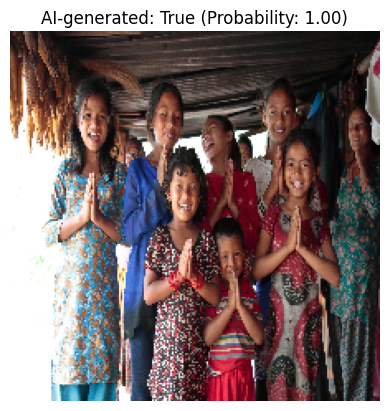

The image is AI-generated.
Probability: 1.00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Define the image path
image_path = "/content/drive/My Drive/Nepalb.jpeg"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image, load_img(image_path, target_size=target_size)

# Load the model
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model_RESNET')

# Preprocess the input image
image, display_image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
probability = prediction[0][0]
is_ai_generated = probability > 0.5

# Display the image and the prediction
plt.imshow(display_image)
plt.title(f"AI-generated: {is_ai_generated} (Probability: {probability:.2f})")
plt.axis('off')
plt.show()

# Print the result
if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")
print(f"Probability: {probability:.2f}")


### Attention implementation

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Multiply, Conv2D, Activation, Lambda, Reshape, Concatenate, Add, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# Verify GPU setup
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

# Define the base path
base_path = "/content/drive/My Drive/preprocessed"

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'

# Load and preprocess the images
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

X = np.array([load_and_preprocess_image(fp) for fp in file_paths])
y = np.array(labels)
y = to_categorical(y, num_classes=2)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, zoom_range=0.2)
val_datagen = ImageDataGenerator()

train_dataset = train_datagen.flow(X_train, y_train, batch_size=32)
val_dataset = val_datagen.flow(X_val, y_val, batch_size=32)

# Attention Mechanism
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_feature)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    return Multiply()([input_feature, cbam_feature])

# Load the ResNet50 model pre-trained on ImageNet and exclude the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add attention mechanism
attention_layer = channel_attention(base_model.output)
attention_layer = spatial_attention(attention_layer)

# Add custom top layers with dropout and regularization
x = GlobalAveragePooling2D()(attention_layer)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[early_stopping])

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
checkpoint = ModelCheckpoint('/content/drive/My Drive/resnet_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Continue training the model with reduced batch size to avoid memory issues
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, reduce_lr, checkpoint])

# Save the trained model
model.save('/content/drive/My Drive/saved_model_Attention')


Num GPUs Available:  1
TensorFlow version: 2.15.0


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
55/55 [==============================] - 25s 370ms/step - loss: 6.1966 - accuracy: 0.8665 - val_loss: 2.0968 - val_accuracy: 0.9192
Epoch 2/5
55/55 [==============================] - 20s 354ms/step - loss: 1.3253 - accuracy: 0.9168 - val_loss: 0.8470 - val_accuracy: 0.9284
Epoch 3/5
55/55 [==============================] - 19s 350ms/step - loss: 0.6656 - accuracy: 0.9231 - val_loss: 0.5228 - val_accuracy: 0.9307
Epoch 4/5
55/55 [==============================] - 19s 352ms/step - loss: 0.4399 - accuracy: 0.9347 - val_loss: 0.4177 - val_accuracy: 0.9307
Epoch 5/5
55/55 [==============================] - 19s 350ms/step - loss: 0.3717 - accuracy: 0.9358 - val_loss: 0.4353 - val_accuracy: 0.9192
Epoch 1/10
55/55 [==============================] - 27s 396ms/step - loss: 0.2956 - accuracy: 0.9445 - val_loss: 0.3486 - val_accuracy: 0.9353 - lr: 1.0000e-04
Epoch 2/10
55/55 [==============================] - 20s 354ms/step - loss: 0.2518 - accuracy: 0.9584 - val_loss: 0.4287 - val_accu

14/14 [==============================] - 1s 96ms/step


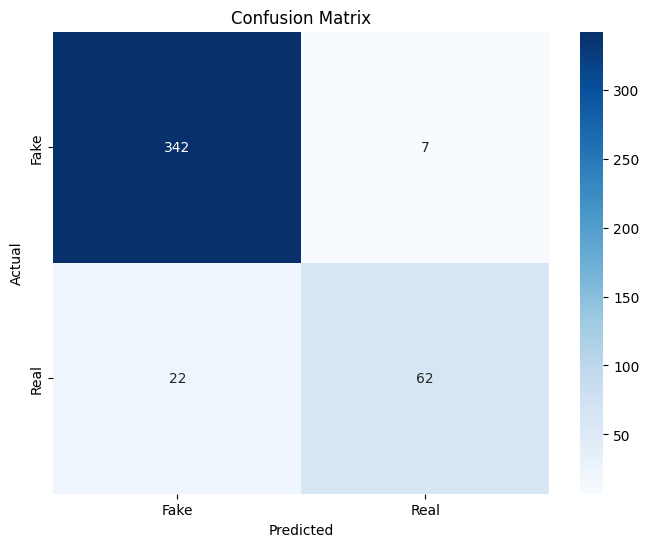

Precision: 0.8985507246376812
Recall: 0.7380952380952381
F1 Score: 0.8104575163398693


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred_classes)
recall = recall_score(y_val_true, y_val_pred_classes)
f1 = f1_score(y_val_true, y_val_pred_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/nepal.png"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model_Attention')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 1s 1s/step
The image is AI-generated.


1/1 [==============================] - 1s 1s/step


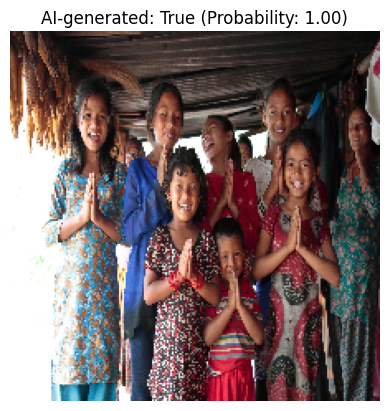

The image is AI-generated.
Probability: 1.00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Define the image path
image_path = "/content/drive/My Drive/Nepalb.jpeg"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image, load_img(image_path, target_size=target_size)

# Load the model
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model_Attention')

# Preprocess the input image
image, display_image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
probability = prediction[0][0]
is_ai_generated = probability > 0.5

# Display the image and the prediction
plt.imshow(display_image)
plt.title(f"AI-generated: {is_ai_generated} (Probability: {probability:.2f})")
plt.axis('off')
plt.show()

# Print the result
if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")
print(f"Probability: {probability:.2f}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/srk.jpg"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/saved_model_Attention')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 1s 1s/step
The image is AI-generated.


Num GPUs Available:  1
TensorFlow version: 2.15.0


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
55/55 [==============================] - 26s 380ms/step - loss: 4.7199 - accuracy: 0.8757 - val_loss: 1.1062 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 2/5
55/55 [==============================] - 20s 367ms/step - loss: 0.7256 - accuracy: 0.9145 - val_loss: 0.5303 - val_accuracy: 0.9215 - lr: 0.0010
Epoch 3/5
55/55 [==============================] - 20s 365ms/step - loss: 0.5115 - accuracy: 0.9133 - val_loss: 0.4353 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 4/5
55/55 [==============================] - 20s 370ms/step - loss: 0.3862 - accuracy: 0.9249 - val_loss: 0.4032 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 5/5
55/55 [==============================] - 20s 368ms/step - loss: 0.3496 - accuracy: 0.9208 - val_loss: 0.3566 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 1/10
55/55 [==============================] - 32s 414ms/step - loss: 0.3531 - accuracy: 0.9214 - val_loss: 0.3560 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 2/10
55/55 [==============================] - 22s 401ms/step - 

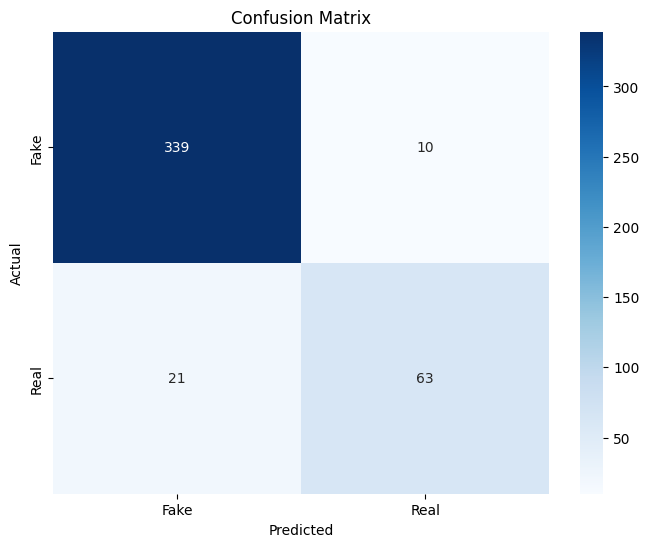

Precision: 0.863013698630137
Recall: 0.75
F1 Score: 0.802547770700637


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Multiply, Conv2D, Activation, Lambda, Reshape, Concatenate, Add, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Verify GPU setup
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

# Define the base path
base_path = "/content/drive/My Drive/preprocessed"

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'

# Load and preprocess the images
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

X = np.array([load_and_preprocess_image(fp) for fp in file_paths])
y = np.array(labels)
y = to_categorical(y, num_classes=2)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, zoom_range=0.2)
val_datagen = ImageDataGenerator()

train_dataset = train_datagen.flow(X_train, y_train, batch_size=32)
val_dataset = val_datagen.flow(X_val, y_val, batch_size=32)

# Attention Mechanism
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(input_feature)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])

    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    return Multiply()([input_feature, cbam_feature])

# Load the ResNet50 model pre-trained on ImageNet and exclude the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add attention mechanism
attention_layer = channel_attention(base_model.output)
attention_layer = spatial_attention(attention_layer)

# Add custom top layers with dropout and regularization
x = GlobalAveragePooling2D()(attention_layer)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Compile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with data augmentation
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[early_stopping, lr_scheduler])

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
checkpoint = ModelCheckpoint('/content/drive/My Drive/resnet_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Continue training the model with reduced batch size to avoid memory issues
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler])

# Save the trained model
model.save('/content/drive/My Drive/saved_model_lr')

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred_classes)
recall = recall_score(y_val_true, y_val_pred_classes)
f1 = f1_score(y_val_true, y_val_pred_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Num GPUs Available:  1
TensorFlow version: 2.15.0


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
55/55 [==============================] - 33s 440ms/step - loss: 0.9030 - accuracy: 0.8353 - val_loss: 0.3107 - val_accuracy: 0.8891 - lr: 0.0010
Epoch 2/5
55/55 [==============================] - 22s 394ms/step - loss: 0.2992 - accuracy: 0.8948 - val_loss: 0.2580 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 3/5
55/55 [==============================] - 21s 384ms/step - loss: 0.2550 - accuracy: 0.9023 - val_loss: 0.2762 - val_accuracy: 0.8915 - lr: 0.0010
Epoch 4/5
55/55 [==============================] - 21s 386ms/step - loss: 0.2625 - accuracy: 0.9104 - val_loss: 0.2829 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 5/5
55/55 [==============================] - 21s 387ms/step - loss: 0.2475 - accuracy: 0.9087 - val_loss: 0.2679 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 1/10
55/55 [==============================] - 36s 559ms/step - loss: 0.2781 - accuracy: 0.9121 - val_loss: 0.6432 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 2/10
55/55 [==============================] - 33s 604ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 3s 146ms/step


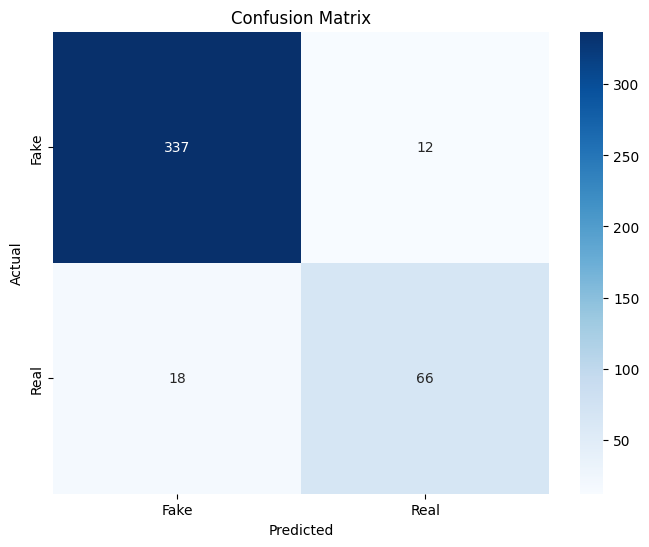

Precision: 0.8461538461538461
Recall: 0.7857142857142857
F1 Score: 0.8148148148148148


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Multiply, Conv2D, Activation, Lambda, Reshape, Concatenate, Add, GlobalMaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Verify GPU setup
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

# Define the base path
base_path = "/content/drive/My Drive/preprocessed"
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'

# Load and preprocess the images
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

X = np.array([load_and_preprocess_image(fp) for fp in file_paths])
y = np.array(labels)
y = to_categorical(y, num_classes=2)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, zoom_range=0.2)
val_datagen = ImageDataGenerator()

train_dataset = train_datagen.flow(X_train, y_train, batch_size=32)
val_dataset = val_datagen.flow(X_val, y_val, batch_size=32)

# Define attention mechanism
def attention_block(x):
    # Channel attention
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    concat = tf.keras.layers.Concatenate()([avg_pool, max_pool])
    channel_attention = tf.keras.layers.Dense(2048, activation='relu')(concat)
    channel_attention = tf.keras.layers.Dense(2048, activation='sigmoid')(channel_attention)

    # Spatial attention
    spatial_attention = tf.keras.layers.Conv2D(2048, (3, 3), activation='relu', padding='same')(x)
    spatial_attention = tf.keras.layers.Conv2D(2048, (3, 3), activation='sigmoid', padding='same')(spatial_attention)

    # Element-wise multiplication
    attention = Multiply()([x, channel_attention, spatial_attention])
    return attention

# Define classification head
def classification_head(x):
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    return x

# Load the ResNet50 model pre-trained on ImageNet and exclude the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Define the model
input_layer = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = base_model(input_layer)
x = attention_block(x)
x = classification_head(x)
model = Model(inputs=input_layer, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Compile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with data augmentation
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[early_stopping, lr_scheduler])

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
checkpoint = ModelCheckpoint('/content/drive/My Drive/resnet_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Continue training the model with reduced batch size to avoid memory issues
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler])

# Save the trained model
model.save('/content/drive/My Drive/resnet_model.h5')

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred_classes)
recall = recall_score(y_val_true, y_val_pred_classes)
f1 = f1_score(y_val_true, y_val_pred_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/suhelsir.jpeg"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/resnet_model.h5')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 2s 2s/step
The image is not AI-generated.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/llama_NEPAL.jpeg"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/resnet_model.h5')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 1s 1s/step
The image is AI-generated.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the image path
image_path = "/content/drive/My Drive/nepal.png"

# Load and preprocess the image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    return image

# Assuming the model is trained for binary classification (AI-generated vs. real)
model = tf.keras.models.load_model('/content/drive/My Drive/resnet_model.h5')

# Preprocess the input image
image = load_and_preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Assuming the output is a probability for AI-generated
is_ai_generated = prediction[0][0] > 0.5

if is_ai_generated:
    print("The image is AI-generated.")
else:
    print("The image is not AI-generated.")


1/1 [==============================] - 1s 1s/step
The image is AI-generated.


In [ ]:

# Step 3: Define the image path
image_path = "/content/drive/My Drive/nepal.png"

# Step 4: Use a pipeline as a high-level helper
from transformers import pipeline
from PIL import Image

# Load the image
image = Image.open(image_path)

# Initialize the pipeline
pipe = pipeline("image-classification", model="Organika/sdxl-detector")

# Perform image classification
results = pipe(image)

# Display results
for result in results:
    print(f"Label: {result['label']}, Score: {result['score']:.4f}")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Label: human, Score: 0.9986
Label: artificial, Score: 0.0014


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Multiply, Concatenate, GlobalMaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.filters import sobel, laplace
from skimage.color import rgb2gray

# Verify GPU setup
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

# Define the base path
base_path = "/content/drive/My Drive/preprocessed"
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'

# Load and preprocess the images
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    return img_array

# Extract texture features
def extract_texture_features(img_array):
    gray_img = rgb2gray(img_array)
    sobel_img = sobel(gray_img)
    laplace_img = laplace(gray_img)
    combined_features = np.stack([sobel_img, laplace_img], axis=-1)
    combined_features = np.repeat(combined_features[..., np.newaxis], 3, axis=-1)
    return combined_features.reshape(IMG_WIDTH, IMG_HEIGHT, 6)

X = np.array([load_and_preprocess_image(fp) for fp in file_paths])
texture_features = np.array([extract_texture_features(img) for img in X])
X = np.concatenate([X, texture_features], axis=-1)
y = np.array(labels)
y = to_categorical(y, num_classes=2)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, zoom_range=0.2)
val_datagen = ImageDataGenerator()

train_dataset = train_datagen.flow(X_train, y_train, batch_size=32)
val_dataset = val_datagen.flow(X_val, y_val, batch_size=32)

# Define attention mechanism
def attention_block(x):
    # Channel attention
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    concat = Concatenate()([avg_pool, max_pool])
    channel_attention = Dense(2048, activation='relu')(concat)
    channel_attention = Dense(2048, activation='sigmoid')(channel_attention)

    # Spatial attention
    spatial_attention = Conv2D(2048, (3, 3), activation='relu', padding='same')(x)
    spatial_attention = Conv2D(2048, (3, 3), activation='sigmoid', padding='same')(spatial_attention)

    # Element-wise multiplication
    attention = Multiply()([x, channel_attention, spatial_attention])
    return attention

# Define classification head
def classification_head(x):
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    return x

# Load the ResNet50 model pre-trained on ImageNet and exclude the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Define the model
input_layer = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 6))  # Adjusted input shape to include texture features
x = base_model(input_layer[..., :3])  # Pass only the first 3 channels to ResNet50
x = Concatenate()([x, input_layer[..., 3:]])  # Concatenate the original ResNet output with texture features
x = attention_block(x)
x = classification_head(x)
model = Model(inputs=input_layer, outputs=x)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Compile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with data augmentation
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[early_stopping, lr_scheduler])

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with the correct parameter for learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
checkpoint = ModelCheckpoint('/content/drive/My Drive/resnet_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Continue training the model with reduced batch size to avoid memory issues
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler])

# Save the trained model
model.save('/content/drive/My Drive/resnet_model.h5')

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred_classes)
recall = recall_score(y_val_true, y_val_pred_classes)
f1 = f1_score(y_val_true, y_val_pred_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Num GPUs Available:  1
TensorFlow version: 2.15.0


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 7, 7, 2048), (None, 224, 224, 3)]

Device: cuda


preprocessor_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5, Loss: 0.20884727046570994
Validation Accuracy: 95.61%
Epoch 2/5, Loss: 0.06487751335635866
Validation Accuracy: 94.69%
Epoch 3/5, Loss: 0.03915921486173333
Validation Accuracy: 96.07%
Epoch 4/5, Loss: 0.02087863620095463
Validation Accuracy: 96.77%
Epoch 5/5, Loss: 0.03668541894256288
Validation Accuracy: 96.77%


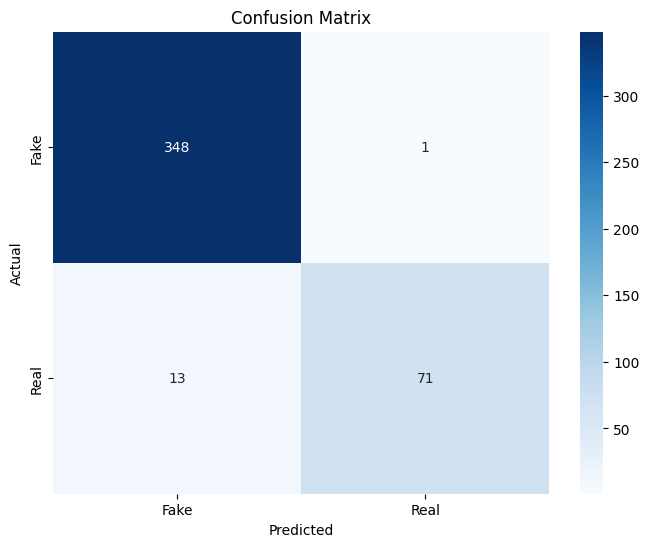

Precision: 0.9861111111111112
Recall: 0.8452380952380952
F1 Score: 0.9102564102564102


In [ ]:
import os
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Verify GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Define the base path
base_path = "/content/drive/My Drive/preprocessed"
IMG_WIDTH, IMG_HEIGHT = 224, 224

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Iterate through 'fake' and 'real' subfolders to collect file paths and labels
for label, category in enumerate(['fake', 'real']):
    category_path = os.path.join(base_path, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(label)  # Assign label 0 for 'fake' and 1 for 'real'

# Load model and processor
processor = AutoImageProcessor.from_pretrained("Organika/sdxl-detector")
model = AutoModelForImageClassification.from_pretrained("Organika/sdxl-detector")
model.to(device)

# Preprocess the images
def load_and_preprocess_image(file_path):
    image = Image.open(file_path).convert("RGB")
    return processor(image, return_tensors="pt").pixel_values

X = torch.cat([load_and_preprocess_image(fp) for fp in file_paths])
y = torch.tensor(labels)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the training loop
def train_model(model, train_loader, val_loader, num_epochs=5):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Accuracy: {100 * correct / total:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, num_epochs=5)

# Evaluate the model
model.eval()
y_val_pred = []
y_val_true = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs.data, 1)
        y_val_pred.extend(predicted.cpu().numpy())
        y_val_true.extend(labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_true, y_val_pred)
recall = recall_score(y_val_true, y_val_pred)
f1 = f1_score(y_val_true, y_val_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


In [ ]:
# Save the trained model
save_directory = "/content/drive/My Drive/sdxl_detector_model"
model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128}


['/content/drive/My Drive/sdxl_detector_model/preprocessor_config.json']